In [2]:
# Import modules, make sure you have installed all required packages before you start.
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Module auto reloading. (Ref: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html)
%load_ext autoreload
%autoreload 2

# MNIST Data

In [3]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

# the integer labels in y_train and y_test correspond to the index of this label map
label_map = [
    't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

# Here we vectorize the data (rearranged the storage of images) for you. 
# That is, we flatten 1×28×28 images into 1×784 Numpy arrays.
# The reason we do this is because we can not put 2-D image representations into our model. 
# This is common practice (flattening images before putting them into the ML models). 
# Note that this practice may not be used for Convolutional Neural Networks (CNN). 
# We will later see how we manage the data when used in CNNs in later assignments.

# Check the results
print('Raw training data shape: ', X_train_raw.shape)
print('Raw test data shape: ', X_test_raw.shape)

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

num_classes = max(y_train) + 1

print('Number of classes: ', num_classes)
print('Vectorized training data shape: ', X_train.shape)
print('Vectorized test data shape: ', X_test.shape)
print('Training labels shape: ', y_train.shape)
print('Test labels shape: ', y_test.shape)

Raw training data shape:  (60000, 28, 28)
Raw test data shape:  (10000, 28, 28)
Number of classes:  10
Vectorized training data shape:  (60000, 784)
Vectorized test data shape:  (10000, 784)
Training labels shape:  (60000,)
Test labels shape:  (10000,)


['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
(60000, 28, 28)


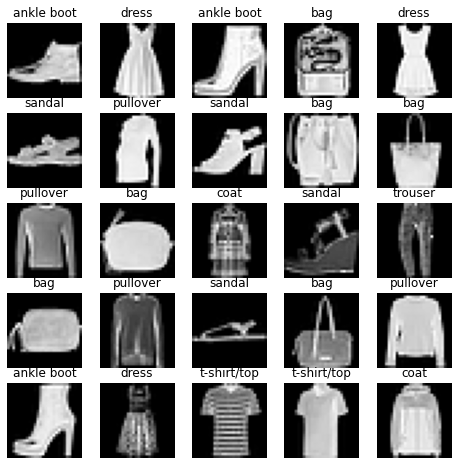

In [4]:
# We need to reshape vectorized data into the image format for visualization
X = X_train.reshape(X_train.shape[0], X_train_raw.shape[1], X_train_raw.shape[2])

print(label_map)
print(X.shape)

#Visualizing Fashion-MNIST data. We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5, 5, figsize=(8, 8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0], cmap='gray')
        axes1[j][k].set_title(label_map[y_train[i]])

In [5]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the train set: indices 1~49,000
#    Development data (binary) (only for gradient check in Part 1): 100 random samples from the subsampled binary train set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100
num_dev_binary = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (1000, 784)
Test labels shape:  (1000,)
Development data shape: (100, 784)
Development data shape (100,)


In [6]:
# Subsample 10-class training set to 2-class training set
X_train_binary = X_train[y_train<2,:]
num_training_binary = X_train_binary.shape[0]
y_train_binary = y_train[y_train<2]
mask_binary = np.random.choice(num_training_binary, num_dev_binary, replace=False)

X_val_binary = X_val[y_val<2,:]
y_val_binary = y_val[y_val<2]

X_dev_binary = X_train_binary[mask_binary]
y_dev_binary = y_train_binary[mask_binary]

print('Train data (binary) shape: ', X_train_binary.shape)
print('Train labels (binary) shape: ', y_train_binary.shape)
print('Validation data (binary) shape: ', X_val_binary.shape)
print('Validation labels (binary) shape: ', y_val_binary.shape)
print('Development data (binary) shape:', X_dev_binary.shape)
print('Development labels (binary) shape', y_dev_binary.shape)

Train data (binary) shape:  (9775, 784)
Train labels (binary) shape:  (9775,)
Validation data (binary) shape:  (207, 784)
Validation labels (binary) shape:  (207,)
Development data (binary) shape: (100, 784)
Development labels (binary) shape (100,)


In [7]:
#############################################################
# Append the bias dimension of ones (i.e. bias trick) so that our models
X_train = np.hstack([X_train, np.ones([X_train.shape[0], 1])])
X_val = np.hstack([X_val, np.ones([X_val.shape[0], 1])])
X_test = np.hstack([X_test, np.ones([X_test.shape[0], 1])])
X_dev = np.hstack([X_dev, np.ones([X_dev.shape[0], 1])])
X_train_binary = np.hstack([X_train_binary, np.ones([X_train_binary.shape[0], 1])])
X_val_binary = np.hstack([X_val_binary, np.ones([X_val_binary.shape[0], 1])])
X_dev_binary = np.hstack([X_dev_binary, np.ones([X_dev_binary.shape[0], 1])])

# END of your code
#############################################################

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("X_dev shape: {}".format(X_dev.shape))
print("X_train_binary shape: {}".format(X_train_binary.shape))
print("X_val_binary shape: {}".format(X_val_binary.shape))
print("X_dev_binary shape: {}".format(X_dev_binary.shape))

X_train shape: (49000, 785)
X_val shape: (1000, 785)
X_test shape: (1000, 785)
X_dev shape: (100, 785)
X_train_binary shape: (9775, 785)
X_val_binary shape: (207, 785)
X_dev_binary shape: (100, 785)


In [15]:
# Logistic Regression 

from classifier import LogisticRegression

## Logistic Regression + SGD
classifier = LogisticRegression()
reg = 1e-3 # regularization
lr = 1e-5 # learning rate
loss_hist_sgd = classifier.train(
    X_train_binary, y_train_binary, 
    learning_rate=lr, reg=reg, 
    num_iters=300, optim='SGD', 
    verbose=True
)

# Write the BasicClassifier.predict function and evaluate the performance 
# on both training set and validation set
y_train_pred = classifier.predict(X_train_binary)
print('training accuracy:', np.mean(y_train_binary == y_train_pred))
y_val_pred = classifier.predict(X_val_binary)
print('validation accuracy:', np.mean(y_val_binary == y_val_pred))

iteration 0 / 300: loss 0.044354
iteration 100 / 300: loss 0.012287
iteration 200 / 300: loss 0.008143
training accuracy: 0.9965217391304347
validation accuracy: 0.9903381642512077


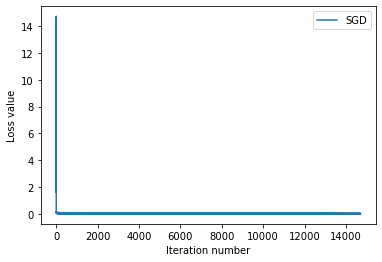

In [16]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()